In [1]:
import pennylane as qml
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib
import matplotlib.pyplot as plt
import csv

In [2]:
# hyper parameters
DATA_SIZE = 20
iters = 200
lr = 0.01
b1 = 0.8
b2 = 0.2
weight_decay = 0

# Domain
x_min = 0
x_max = 0.9

# DoubleTensor
dtype = torch.DoubleTensor

# random seed
torch.random.manual_seed(11)

# one
one = Variable(torch.Tensor([1]).type(dtype))

# bondary/initial condition
t0 = 0
x0_1 = 1
     
# Analytic solution
def Analytic_sol(x):
    y = torch.exp((-x ** 2)/2)/(1+x+x**3) + x**2
    return y

In [3]:
# quamtum circuit
dev = qml.device('default.qubit', wires=2)

def state(a0, a1):
    qml.RY(a0, wires=0)
    qml.RY(a1, wires=1)
    qml.CNOT(wires = [0, 1])

def layers(W):
    qml.RY(W[0, 0], wires=0)
    qml.RY(W[1, 0], wires=1)
    qml.CNOT(wires = [0, 1])
    qml.RY(W[0, 1], wires=0)
    qml.RY(W[1, 1], wires=1)

def function(a0, weights, out_weights, bias, t0, x0_1):
    tmp = circuit(torch.asin(a0)[0], torch.asin(a0)[0], weights) # raw output
    adjust = x0_1 + (a0-t0)*(out_weights[0]*tmp[0] + out_weights[1]*tmp[1] + bias)
    return adjust

def dy_dx(a0, weights, out_weights, bias, t0, x0_1):
    tmp_0 = circuit(torch.asin(a0)[0], torch.asin(a0)[0], weights)
    tmp_1 = (1/2)*(1/(1-a0**2)**0.5)*(circuit(torch.asin(a0)[0] + np.pi/2, torch.asin(a0)[0], weights) - circuit(torch.asin(a0)[0] - np.pi/2, torch.asin(a0)[0], weights))
    tmp_2 = (1/2)*(1/(1-a0**2)**0.5)*(circuit(torch.asin(a0)[0], torch.asin(a0)[0] + np.pi/2, weights) - circuit(torch.asin(a0)[0], torch.asin(a0)[0] - np.pi/2, weights))
    adjust = out_weights[0]*tmp_0[0] + out_weights[1]*tmp_0[1] + bias + (a0-t0)*(out_weights[0]*(tmp_1[0]+tmp_2[0]) + out_weights[1]*(tmp_1[1]+tmp_2[1]))
    return adjust
    
@qml.qnode(dev, interface="torch")
def circuit(a0, a1, weights): # qubit
    state(a0, a1)
    for W in weights:
        layers(W)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)] # raw output

In [4]:
weights = Variable(torch.randn(1, 2, 2).type(dtype), requires_grad=True)
out_weights = Variable(torch.randn(2).type(dtype), requires_grad=True)
bias = Variable(torch.zeros(1).type(dtype), requires_grad=True)

# save initial parameters
with open('weights.csv','a') as f:
    writer = csv.writer(f)
    shape_i, shape_j, shape_k = weights.shape
    for j in range(shape_j):
        for k in range(shape_k):
            f.write(str(weights[0][j][k].item()) + "\n")
with open('out_weights.csv','a') as f:
    writer = csv.writer(f)
    shape_i = out_weights.shape[0]
    for i in range(shape_i):
        f.write(str(out_weights[i].item()) + "\n")
with open('bias.csv','a') as f:
    writer = csv.writer(f)
    shape_i = bias.shape[0]
    for i in range(shape_i):
        f.write(str(bias[i].item()) + "\n")

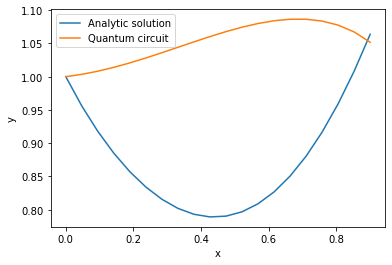

In [5]:
# Domain
x = torch.linspace(x_min, x_max, steps = DATA_SIZE)

# Initial
y_output = []

for i in range(DATA_SIZE):
    x_new = Variable(torch.tensor([x[i]]))
    tmp = function(x_new, weights, out_weights, bias, t0, x0_1).data
    y_output.append(tmp)

plt.plot(x, Analytic_sol(x), label = "Analytic solution")
plt.plot(x, y_output, label = "Quantum circuit")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [6]:
loss_plt = []
def mse_loss(y):
    loss = y**2
    return loss

In [7]:
optimizer = torch.optim.Adam([weights, out_weights, bias], lr=lr, betas=(b1, b2), eps=1e-08, weight_decay=weight_decay, amsgrad=False)

for i in range(iters):
    loss = 0
    for j in range(DATA_SIZE):
        x_new = Variable(torch.tensor([x[j]]))
        y = function(x_new, weights, out_weights, bias, t0, x0_1)
        y_dot = dy_dx(x_new, weights, out_weights, bias, t0, x0_1)
        diff_equ = y_dot + (x_new +(1 + 3*x_new**2)/(1+x_new+x_new**3))*y - x_new **3 - 2*x_new - ((1+3*x_new**2)/(1+x_new+x_new**3))*x_new**2
        loss = loss + mse_loss(diff_equ)
    loss = loss / DATA_SIZE
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    loss_plt.append(loss.item())
    optimizer.step()
    print("Iteration:" + str(i+1) + " loss = " + str(loss.item()))
    
    # save parameters
    with open('weights.csv','a') as f:
        writer = csv.writer(f)
        shape_i, shape_j, shape_k = weights.shape
        for j in range(shape_j):
            for k in range(shape_k):
                f.write(str(weights[0][j][k].item()) + "\n")
    with open('out_weights.csv','a') as f:
        writer = csv.writer(f)
        shape_i = out_weights.shape[0]
        for i in range(shape_i):
            f.write(str(out_weights[i].item()) + "\n")
    with open('bias.csv','a') as f:
        writer = csv.writer(f)
        shape_i = bias.shape[0]
        for i in range(shape_i):
            f.write(str(bias[i].item()) + "\n")

Iteration:1 loss = 0.6634129788943979
Iteration:2 loss = 0.6357306032503863
Iteration:3 loss = 0.6093385179056489
Iteration:4 loss = 0.5833974139311088
Iteration:5 loss = 0.5583933980573399
Iteration:6 loss = 0.5331763042507354
Iteration:7 loss = 0.5078236781681974
Iteration:8 loss = 0.4824569339278641
Iteration:9 loss = 0.45714581491297973
Iteration:10 loss = 0.4319465327186493
Iteration:11 loss = 0.406917080454653
Iteration:12 loss = 0.38212235975278536
Iteration:13 loss = 0.35763671752757004
Iteration:14 loss = 0.33354785999279163
Iteration:15 loss = 0.3099649028635565
Iteration:16 loss = 0.2870366599586055
Iteration:17 loss = 0.26500371805686707
Iteration:18 loss = 0.24441352038124037
Iteration:19 loss = 0.22791945201003228
Iteration:20 loss = 0.21710181026969133
Iteration:21 loss = 0.20300357008091985
Iteration:22 loss = 0.18734797190589916
Iteration:23 loss = 0.1710938757972466
Iteration:24 loss = 0.1552269824975438
Iteration:25 loss = 0.14118807474710554
Iteration:26 loss = 0.13

Iteration:198 loss = 0.0006969601002467233
Iteration:199 loss = 0.0011592851111201005
Iteration:200 loss = 0.0014265068799180149


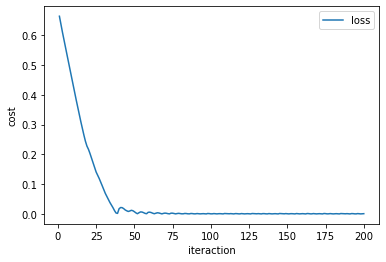

In [8]:
# Loss plot
a = np.linspace(1, len(loss_plt), len(loss_plt))

plt.plot(a, loss_plt, label = "loss")
plt.xlabel("iteraction")
plt.ylabel("cost")
plt.legend()
plt.show()

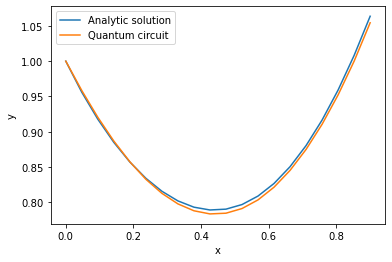

In [9]:
# result
x = torch.linspace(x_min, x_max, steps = DATA_SIZE)

# Initial
y_output = []

for i in range(DATA_SIZE):
    x_new = Variable(torch.tensor([x[i]]))
    tmp = function(x_new, weights, out_weights, bias, t0, x0_1).data
    y_output.append(tmp)

plt.plot(x, Analytic_sol(x), label = "Analytic solution")
plt.plot(x, y_output, label = "Quantum circuit")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()